Нам належить запропонувати свою власну архітектуру мережі. Точність найнаївнішої, але адекватної нейромережі становить приблизно 91%. Точність вашої моделі повинна бути не нижчою за цей показник. Щоб досягти таких значень вам знадобиться поекспериментувати з гіперпараметрами мережі:

кількість шарів;

кількість нейронів;

функції активації;

кількість епох;

розмір батчу;

вибір оптимізатора;

різні техніки регуляризації і т.д.

Використайте вивчені техніки виявлення проблем навчання нейронної мережі, і потім поекспериментуйте.

Займемся этим вопросом

In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [36]:
num_classes = 10 # общее количество классов, в нашем случае это вещи в количестве 10 классов
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети - множитель оптимизатора
num_epochs = 100 # максимальное число эпох
batch_size = 1024 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
                # это число стараются выбирать как степень двойки - чтобы была возможность проводить обучение на GPU

n_hidden_1 = 1024 # количество нейронов 1-го слоя
n_hidden_2 = 2048 # количество нейронов 2-го слоя
n_hidden_3 = 1024 # третий слой

drop_rate_1 = 0.05
drop_rate_2 = 0.1
drop_rate_3 = 0.5

In [37]:
from keras.datasets import fashion_mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

Рассмотрим подробней тренировочные и тестовые данные

In [38]:
print(x_train.shape)
print(len(x_train))
print(y_train.shape)
print(np.max(y_train))
y_train

(60000, 28, 28)
60000
(60000,)
9


array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Видим, что обучающий набор состоит из 60000 изображений разменостью 28*28 пикселов, тензор y_train - из соответсвующих меток классов размерностью 0-9, то есть 10

Аналогично для контрольного набора

In [39]:
print(x_test.shape)
print(len(x_test))
print(y_test.shape)
print(np.max(y_test))
y_test

(10000, 28, 28)
10000
(10000,)
9


array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

Тестовый набор аналогичен обучаещему, но меньше в 6 раз - 10000 образцов

Для постоения модели нейрнной сети воспользуемся нашим прошлым опытом - мы строили уже сеть распознающую изображения 28 на 28 пикселов. Эта сеть состояла из 2 внутренних полносвязных слоев и выходного слоя.

1) у нас большое количество данных - поэтому нам не нужно формировать данные для теста с помощью K выборок или с перекрестными выборками с перемешиванием

2) Нельзя выбирать большое количество нейронов во внутренних слоях - такая сеть резко склонна к переобучению

3) наша задача - многоклассовая однозначная классификация, поэтому в соответсвие с общщими практиками выбиарем фугкции активации для внутренних слоев - relu, для выходного слоя - softmax, фугкция потерь - категориальная кроссэнтропия

In [40]:
# подготовка данных

# Преобразуем целочисленные пиксели к типа float32 и сразу развернем матрицу 28*28 в вектор
x_train = tf.reshape(tf.cast(x_train, tf.float32), [-1, num_features])
x_test = tf.reshape(tf.cast(x_test, tf.float32), [-1, num_features])

# Нормализуем значения пикселей в диапазон 0-1
x_train = x_train / 255.
x_test = x_test / 255.

# преобразование к виду ванхот векторов для віходніх значений меток
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Перемешаем тренировочные данные
#train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#train_data = train_data.repeat().shuffle(buffer_size=1024).batch(batch_size).prefetch(1)

In [41]:
# создаем свою нейронную  сеть
from keras import models
from keras import layers
from keras import losses
from keras import optimizers
from keras import regularizers
from keras import callbacks


model = models.Sequential()
model.add(layers.Dense(n_hidden_1,  #kernel_regularizer= regularizers.l2(l2= 0.005),
                       activation= 'relu', input_shape=(num_features, ), name= 'input_hidden_1'))
model.add(layers.Dropout(drop_rate_1))
model.add(layers.Dense(n_hidden_2,  #kernel_regularizer= regularizers.l2(l2= 0.005),
                       activation= 'relu', name= 'hidden_2'))
model.add(layers.Dropout(drop_rate_2))
model.add(layers.Dense(n_hidden_3,  #kernel_regularizer= regularizers.l2(l2= 0.005),
                       activation= 'relu', name= 'hidden_3'))
model.add(layers.Dropout(drop_rate_3))
model.add(layers.Dense(num_classes, activation= 'softmax', name= 'output'))

#настраиваем обратный вызов, чтоб не тратить лишнее время на обучение при подборе гиперпараметров
callbacks = [callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=1, verbose=1)
             ]

model.compile(optimizer= optimizers.Adam(learning_rate=learning_rate),
              loss= losses.categorical_crossentropy,
              metrics='accuracy')

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    shuffle=True,
                    #callbacks=callbacks,
                    validation_split=0.2)

Epoch 1/100
47/47 [==============================] - 36s 763ms/step - loss: 0.6764 - accuracy: 0.7602 - val_loss: 0.4245 - val_accuracy: 0.8448
Epoch 2/100
47/47 [==============================] - 33s 704ms/step - loss: 0.3853 - accuracy: 0.8624 - val_loss: 0.3742 - val_accuracy: 0.8618
Epoch 3/100
47/47 [==============================] - 34s 731ms/step - loss: 0.3371 - accuracy: 0.8776 - val_loss: 0.3613 - val_accuracy: 0.8686
Epoch 4/100
47/47 [==============================] - 33s 702ms/step - loss: 0.3065 - accuracy: 0.8867 - val_loss: 0.3380 - val_accuracy: 0.8778
Epoch 5/100
47/47 [==============================] - 35s 742ms/step - loss: 0.2793 - accuracy: 0.8969 - val_loss: 0.3094 - val_accuracy: 0.8863
Epoch 6/100
47/47 [==============================] - 34s 720ms/step - loss: 0.2667 - accuracy: 0.9013 - val_loss: 0.3373 - val_accuracy: 0.8773
Epoch 7/100
47/47 [==============================] - 34s 726ms/step - loss: 0.2550 - accuracy: 0.9039 - val_loss: 0.2988 - val_accuracy:

In [42]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 5s 16ms/step - loss: 0.6385 - accuracy: 0.8986


[0.638516902923584, 0.8985999822616577]

In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_hidden_1 (Dense)      (None, 1024)              803840    
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 hidden_2 (Dense)            (None, 2048)              2099200   
                                                                 
 dropout_13 (Dropout)        (None, 2048)              0         
                                                                 
 hidden_3 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0         
                                                                 
 output (Dense)              (None, 10)               

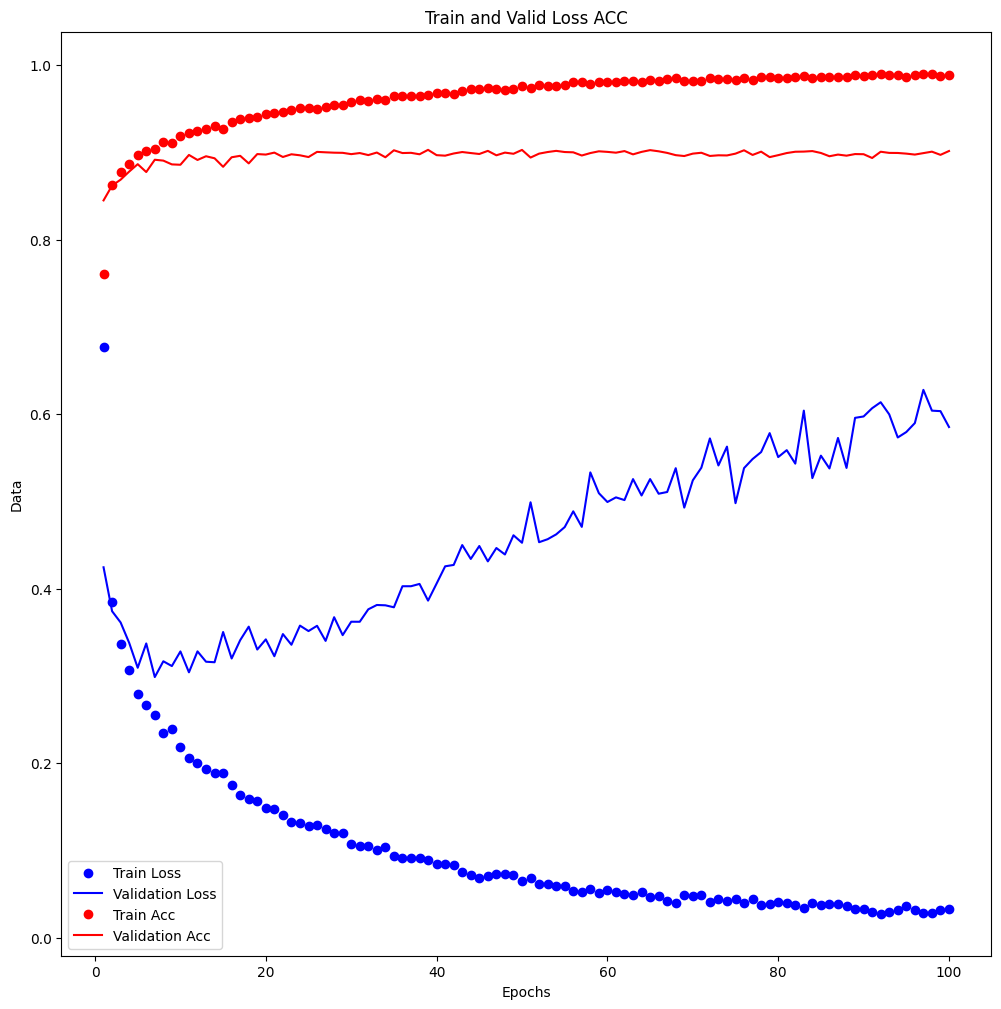

In [48]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epohs = range(1, num_epochs+1)

plt.figure(figsize=(12,12))
plt.plot(epohs, loss_values, 'bo', label= 'Train Loss')
plt.plot(epohs, val_loss_values, 'b', label= 'Validation Loss')
plt.plot(epohs, acc_values, 'ro', label= 'Train Acc')
plt.plot(epohs, val_acc_values, 'r', label= 'Validation Acc')
plt.title('Train and Valid Loss ACC')
plt.xlabel('Epochs')
plt.ylabel('Data')
plt.legend()

plt.show()

Подбор гиперпараметров является итеративным процессом и требует множества экспериментов и оценки производительности модели. Результаты и производительность модели также могут зависеть от конкретной задачи и набора данных, поэтому рекомендуется проводить подбор гиперпараметров на каждой конкретной задаче. К удивлению (или к радости) наиболее эффективным есть - метод - Случайный поиск (Random Search) вместо Заданной Сетки парметров(Grid Search). Суть - в случайном (основанном на опыте скорее) изменении разных параметров в широких пределах и последующем их уточннии, когда нащупали необходимый вектор движения. Существует также метод Байесовской оптимизации. А общий алгоритм постоения сети следующий - начать строить сеть, склонную к переобучению (увеличить слои, увеличить параметры в слое, увеличить количество проходов на обучение - количество эпох). А далее параметрами регуляризации уменьшать степень переобученности сети, ловя ту тонкую грань между недообученостью и переобученость. Полученный результат и будет оптимальная сеть при выбранной архикетуре.

Мы получили точность около 90% (в обучении на некоторых эпохах 90.5%) на полносвязной сети из 3 слоев плюс выходной слой. Для улучшения этого параметра необходимо применить сверточную сеть, как специально разработанную для клиссификации изображений.